## 分析A/B测试结果

这个项目可以帮你确认你已经掌握了统计课程中涵盖的所有内容。 希望这个项目尽可能地涵盖所有内容。 祝你好运！

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

通常情况下，A/B 测试由数据分析师和数据科学家来完成。如果你在一些实践工作中遇到过这方面的问题，那学习起来就会更加游刃有余。

对于这个项目，你将要了解的是电子商务网站运行的 A/B 测试的结果。你的目标是通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

**使用该 notebook 的时候，请同步学习课堂内容，并回答与每个问题相关的对应测试题目。** 每个课堂概念的标签对应每个题目。这样可以确保你在完成项目的过程中的方法正确，并且你最终提交的内容会更加符合标准，不必担心出现错误。最后检查的时候，请确保你的提交内容符合 [审阅标准](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric) 中的所有标准。

<a id='probability'></a>
#### I - 概率

让我们先导入库，然后开始你的任务吧。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  **使用你的 dataframe 来回答课堂测试 1 中的问题。**

a. 导入数据集，并在这里查看前几行：

In [2]:
ab_data = pd.read_csv('ab_data.csv')
ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 使用下面的单元格来查找数据集中的行数。

In [3]:
ab_data.shape

(294478, 5)

> 数据集有294478行

c. 数据集中独立用户的数量。

In [4]:
ab_data.user_id.nunique()

290584

> 数据集里单独用户数:290584

d. 用户转化的比例。

In [5]:
ab_data[ab_data.converted == 1].count()[0] / ab_data.count()[0]

0.11965919355605512

> 用户转换比例:12%

e.  `new_page` 与 `treatment` 不一致的次数。

In [6]:
treatment = ab_data['group'] == 'treatment'
new_page  = ab_data['landing_page'] == 'new_page'
mismatch  = treatment != new_page
mismatch.sum()

3893

> 我们要保证控制组(control)访问旧页面(old_page)，试验组(treatment)访问新页面(new_page)  
> 但是有3893行数据出现不匹配的情况  
> 为防止数据干扰，需要将这些数据删除


f. 是否有任何行存在缺失值？

In [7]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


> 该数据集没有缺失值

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。我们应该如何处理这些行？在课堂中的 **测试 2** 中，给出你的答案。  

a. 现在，使用测试题的答案创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [8]:
df2 = ab_data[~mismatch].copy() # 使用 ~ 排除不一致的数据

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2.shape

(290585, 5)

`3.` 使用 **df2** 与下面的单元格来回答课堂中的 **测试3** 。

a.  **df2** 中有多少唯一的 **user_id**?

In [11]:
df2.user_id.nunique()

290584

> df2中有290584个唯一的user_id

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [12]:
df2.user_id.value_counts().head(1)

773192    2
Name: user_id, dtype: int64

> df2中重复的user_id为773192

c. 这个重复的  **user_id** 的行信息是什么？

In [13]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


> 这个 id 具有一致性，我们可以选择任意一个进行删除。我们不应该对同一个用户计数多次。

d. 删除 **一个** 含有重复的 **user_id** 的行， 但需要确保你的 dataframe 为 **df2**。

In [14]:
df2.drop(df2[df2.user_id == 773192].index[0], inplace=True)
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` 在下面的单元格中，使用 **df2** 来回答与课堂中的 **测试 4** 相关的测试题目。

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [15]:
df2.converted.mean()

0.11959708724499628

> 任意页面中的转化概率:0.1196

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [16]:
control = df2.query('group == "control"')

In [17]:
control_ctr = control.converted.mean()
control_ctr

0.1203863045004612

> 假定收到控制组页面的个人，他们的转化率:0.1204

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [18]:
treatment = df2.query('group == "treatment"')
treatment_ctr = treatment.converted.mean()
treatment_ctr

0.11880806551510564

> 假定收到 试验组 页面的个人，他们的转化率:0.1188

d. 一个用户收到新页面的概率是多少？


In [19]:
new_page = df2.query('landing_page == "new_page"')
new_page_ctr = new_page.count()[0] / df2.count()[0]
new_page_ctr

0.5000619442226688

> 收到 新页面（new page)的概率:0.5001

e. 使用这个问题的前两部分的结果，给出你的建议：你是否认为有证据表明一个页面可以带来更多的转化？在下面写出你的答案。

**根据控制组转化率和试验组转化率数据，没有证据表明新的页面可以带来更多的转化。**

<a id='ab_test'></a>
### II - A/B 测试

请注意，由于与每个事件相关的时间戳，你可以在进行每次观察时连续运行假设检验。  

然而，问题的难点在于，一个页面被认为比另一页页面的效果好得多的时候你就要停止检验吗？还是需要在一定时间内持续发生？你需要将检验运行多长时间来决定哪个页面比另一个页面更好？

一般情况下，这些问题是A / B测试中最难的部分。如果你对下面提到的一些知识点比较生疏，请先回顾课程中的“描述统计学”部分的内容。

`1.` 现在，你要考虑的是，你需要根据提供的所有数据做出决定。如果你想假定旧的页面效果更好，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，那么，你的零假设和备择假设是什么？ 你可以根据单词或旧页面与新页面的转化率 **$p_{old}$** 与 **$p_{new}$** 来陈述你的假设。



零假设  

**$H_{0}$** ： **$p_{new}$** - **$p_{old}$** ≤ 0 

备择假设  

**$H_{1}$** ：**$p_{new}$** - **$p_{old}$** > 0 

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>

使用下面的单元格提供这个模拟的必要内容。如果现在还没有完整的意义，不要担心，你将通过下面的问题来解决这个问题。你可以通过做课堂中的 **测试 5** 来确认你掌握了这部分内容。<br><br>

a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c.  $n_{new}$ 是多少？

In [22]:
n_new = treatment.count()[0]
n_new

145310

d.  $n_{old}$?是多少？

In [23]:
n_old = control.count()[0]
n_old

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [24]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=(1-p_new, p_new))

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [25]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=(1-p_old, p_old))

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.0007756278692130358

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [27]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=(1-p_new, p_new))
    old_page_converted = np.random.choice([0, 1], size=n_old, p=(1-p_old, p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [28]:
p_diffs = np.array(p_diffs)

i. 绘制一个 **p_diffs** 直方图。这个直方图看起来像你所期望的吗？通过回答课堂上的匹配问题，确保你完全理解这里计算出的内容。

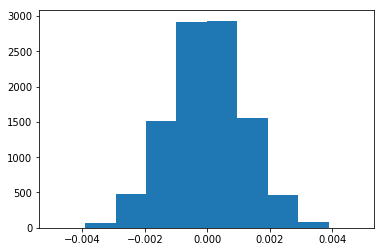

In [29]:
plt.hist(p_diffs);

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

In [30]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

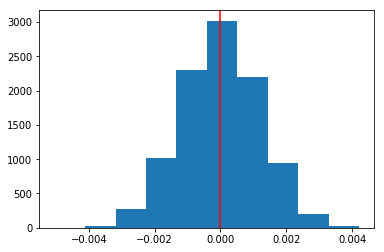

In [31]:
plt.hist(null_vals);
plt.axvline(x=(p_new - p_old), color='r');

In [32]:
p_value = (null_vals > (treatment_ctr - control_ctr)).mean()
p_value

0.9073

k. 用文字解释一下你刚才在 **j.**中计算出来的结果。在科学研究中，这个值是什么？ 根据这个数值，新旧页面的转化率是否有区别呢？



> 刚才在**j.**中计算出来的结果是科学研究中的p值。  
> 由统计数字观察出，p值大于一类错误的阈值，所以我们无法拒绝零假设

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [33]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')
convert_new = df2.query('landing_page == "new_page"')
n_old = convert_old.count()[0]
n_new = convert_new.count()[0]

In [34]:
# 新旧页面各转化成功个数
old_convert = convert_old[convert_old.converted == 1].count()[0]
new_convert = convert_new[convert_new.converted == 1].count()[0]

m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [35]:
z_score, p_value = sm.stats.proportions_ztest([old_convert, new_convert], [n_old, n_new], alternative='smaller')

In [36]:
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. 根据上题算出的 z-score 和 p-value，我们认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 中的结果一致吗？


> 根据上面算出的 `z-score` 和 `p-value` ，我们认为新旧页面的转化率基本没有差别，这与上面 **j.** 与 **k.** 中的结果保持一致。

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

> 我们使用逻辑回归来执行拟合

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [37]:
# 创建虚拟变量
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop('old_page', axis=1)
# 创建截距
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1



c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [38]:
# 创建模型
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
# 拟合
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 01 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        18:27:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [40]:
1 / np.exp(-0.015)

1.015113064615719

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？


> 与`ab_page`关联的 p-值为0.19。  
> 在回归模型中给出的`p-`值中，零假设和备择假设分别是：  
> **$H_{0}$** ： **$ \beta_{1}=0 $**   
> **$H_{1}$** ： **$ \beta_{1}\neq0 $**   
> 而我们在上面的假设检验中做的零假设和备择假设分别是：  
> **$H_{0}$** ： **$p_{new}$** - **$p_{old}$** ≤ 0      
> **$H_{1}$** ： **$p_{new}$** - **$p_{old}$** > 0   
> 故此，我们回归模型中的`p-`值与上面假设检验中的不一样。

> `p>|t|`这一列中，数值越大，解释变量就没有通过显著性检验，即拒绝原假设。
> 在回归中p值通常用于测试，这些p值可以迅速查看特定变量是否有利于预测反应变量。



f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？


> 因为由于实际一个变量仅受单个因素的影响情况极少，所以在回归模型中考虑其他因素能够使模型更趋近真实。但是添加附加项同时也会造成一下潜在问题，如：
> 1. 反映变量和预测变量之间可能不存在线性关系
> 2. 可能具有相关性误差
> 3. 可能不具有误差的常数方差
> 4. 可能具有破坏模型的离群值或杠杆点
> 5. 可能存在更多的线性度

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [41]:
# 将用户所在国家或地区添加到数据中
df3 = df2.join(pd.read_csv('countries.csv').set_index('user_id'), on='user_id')

In [42]:
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [43]:
# 创建三个虚拟变量
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
# 删除一列
df3 = df3.drop('US', axis=1)

In [44]:
# 创建模型
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK']])
# 拟合
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 01 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        18:27:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

> 通过统计结果，可以观察出国家或地区对转化结果没有影响。

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [45]:
df3['new_CA'] = df3['ab_page'] * df3['CA']
df3['new_UK'] = df3['ab_page'] * df3['UK']


In [46]:
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,new_CA,new_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,0,0


In [47]:
# 创建模型
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'new_CA', 'new_UK', 'CA', 'UK']])
# 拟合
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Nov 2018   Pseudo R-squ.:               3.482e-05
Time:                        18:27:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
new_CA        -0.0469      0.054     -0.872      0.383      -0.152       0.059
new_UK         0.0314      0.027      1.181      0.238      -0.021       0.084
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
==============================================================================
"""

In [48]:
1 / np.exp(-0.0469), np.exp(0.0314)

(1.048017202119183, 1.0318981806179213)

> 通过统计结论，`new_CA`与`new_UK`是交叉项,  
> 在其他变量保持不变的情况下，交叉基准项`old_US`是`new_CA`的概率的1.05倍；   
> 在其他变量保持不变的情况下，`new_UK`是交叉基准项`old_US`概率的1.03倍。

<a id='conclusions'></a>
## 总结
> 根据我们的假设检验的统计结果，我们无法反对零假设，即对于页面的改变转化率并没有显著提高。  
> 通过逻辑回归的拟合模型结果，可以观察出，国家和地区项对转化没有影响。  


> 最后根据我们的A/B测试结果，最后得出结论：不推荐该电商发布新页面。


祝贺你顺利完成了该项目！

### 收集提交材料

你对你的 notebook 的状态感到满意后，应该将其保存为便于其他人阅读并查看的格式。你可以使用 __File -> Download as -> HTML (.html)__ 菜单将你的 Notebook 保存为一个 .html 文件。如果你在本地操作，并发现了一个 "找不到模块名称（No module name）" 错误，请打开终端并尝试使用 `pip install <module_name>` 安装缺少的模块（注：在模块名称中，不要包含 "<" or ">" 或任何带有期限的词汇）。

你需要同时提交原始 Notebook 和 Notebook 的HTML或PDF副本以供审阅。你不需要在提交中附带任何数据文件。如果你参考了其他网站、书籍和其他资源来帮助你解决项目中的任务，请确保记录在案。建议你在 Notebook报告末尾的 Markdown 单元格中添加 “Resources” 部分，或者可以附带一个记录你的参考资源的 `readme.txt` 文件。

### 提交项目

准备就绪后，点击“提交项目”按钮进入项目提交页面。你可以将文件以 .zip压缩文件提交，也可以链接到包含项目文件的 GitHub 存储库。如果你使用的是 GitHub，请注意，你提交的内容将是提交时的链接库的一个快照。建议你将每个项目保存在一个单独的存储库中，以避免出现混淆：如果审阅专家获取多个文件夹来代表多个项目，则他可能不明确要评估哪个项目。

我们需要一周的时间对项目进行评分，但在大多数情况下，速度要快得多。当你的提交被审阅后，你将会收到一封电子邮件。如果你在提交项目时遇到任何问题，或者想要查看提交状态，请发送电子邮件至 support@youdaxue.com。同时，你可以继续学习下一个单元的课程。